In [1]:
import numpy as np
from dataset_configs.h36m.utils import ydown2zup, calc_B_param, calc_D_param
from wimusim import WIMUSim, Optimizer, utils
import matplotlib.pyplot as plt

pybullet build time: Nov 28 2023 23:51:11


# Generating Initial Dynamics and Body Parameters from 3D Pose Estimation Data

## Introduction
The main purpose of this notebook is to demonstrate how to generate initial **Body (B)** and **Dynamics (D)** parameters using 3D pose estimation data produced by **MotionBERT**. The **Body (B)** parameters define the structural characteristics of the human body, such as limb lengths and joint configurations, while the **Dynamics (D)** parameters represent the temporal sequence of joint orientations for each segment of the body and the translation of the whole body.

In addition to generating B and D parameters, we will also demonstrate how to use these parameters to generate **virtual IMU data** using WIMUSim. We will define a virtual IMU at a specified position (e.g., on the Right Lower Arm) and simulate accelerometer and gyroscope signals for this IMU.

### **What We Will Do in This Notebook**
1. **Load 3D Pose Estimation Data**: Load the 3D joint positions generated by MotionBERT for a sample sequence.
2. **Convert to Z-Up Coordinate System**: Transform the original data to a standard Z-up coordinate system for consistency with the WIMUSim environment.
3. **Calculate Initial Body (B) Parameters**: Estimate body parameters based on the given 3D joint positions.
4. **Calculate Dynamics (D) Parameters**: Compute both orientation quaternions and translation vectors for each joint.
5. **Define Placement (P) Parameters**: Define a virtual IMU placement for testing the simulation.
6. **Define Hardware (H) Parameters**: Set up hardware-specific configurations for the IMU.
7. **Create a WIMUSim Environment**: Initialize WIMUSim with the generated parameters and simulate virtual IMU data.
8. **Visualize the Simulation Results**: Visualize and analyze the generated IMU data.

## 1 Load 3D Pose Estimation Data
The first step is to load the 3D pose estimation data produced by MotionBERT. This data contains a sequence of 3D joint positions for each frame of a motion sequence. Ensure that you have set the correct path to the MotionBERT output file.

> **Note**: You can download a sample 3D pose estimation data from [this link](https://sussex.box.com/s/57ujzh7h2za78honn0ohrr3ghn30jilq) and set the path to the data in the `motion3d_path` variable.


In [2]:
motion3d_path = "../../WIMUSim/data/motion3d/X3D.npy" # available at https://....
motion3d =  np.load(motion3d_path)

## **2. Convert to Z-Up Coordinate System**

3D pose estimation data often uses a different coordinate system, y-down in this case. To ensure consistency with WIMUSim’s coordinate system, we will convert the original data to a **Z-up** system using the `ydown2zup` function.

In [3]:
# Convert the 3D pose to z-up coordinate system
motion_zup = ydown2zup(motion3d)

## **3. Calculate Initial Body (B) Parameters**

The **Body (B)** parameters describe the structure of the human body, including limb lengths and joint configurations. These parameters are derived from the average length of each body segment in the 3D pose data. We will use the `calc_B_param` function to compute these parameters and scale them to a target height (e.g., 1.7 meters).

In [4]:
# Calculate Body parameters based on the 3D pose
# The target height specifies the expected height of the human model (in meters)
B_dict, scale = calc_B_param(motion_zup, target_height=1.7, return_scale=True)

## **4. Calculate Initial Dynamics (D) Parameters**

The **Dynamics (D)** parameters represent the temporal sequence of joint orientations and translations. To compute these parameters, we need to estimate:
1. **Root Joint Orientation**: Calculate the global orientation of the root joint using the `calc_root_orientation` function.
2. **Relative Orientations for Child Joints**: Calculate the relative orientation of each joint with respect to its parent joint.

### Calculating Dynamics Parameters
The `calc_D_param` function is used to compute both the orientation and translation for each joint. This function has been updated to incorporate the **translation** information in addition to orientation quaternions.


In [37]:
D_dict = calc_D_param(motion_zup, B_dict, scale=scale, enable_translation=True)

## **5. Define Placement (P) Parameters**

We will define the placement parameters for a virtual IMU positioned on the **Right Lower Arm (RLA)**. The IMU is placed 0.25 meters away from the **R_ELBOW** joint (parent joint) in the direction of the x-axis and 3 cm up from the elbow in the z-axis.

In [38]:
P_dict = {
    "rp": {
        ("R_ELBOW", "RLA"): np.array([0.25, 0, 0.03]),
    },
    "ro": {
        ("R_ELBOW", "RLA"): np.deg2rad(np.array([0, 0, 0])),
    }
}

## Define Hardware (H) Parameters

We will define the hardware parameters for the RLA IMU. These parameters include the gyroscope and accelerometer noise levels and biases. We will use default values for these parameters in this example.

In [15]:
H_dict = utils.generate_default_H_configs(["RLA"])

In [30]:
H_dict

{'ba': {'RLA': array([0., 0., 0.])},
 'bg': {'RLA': array([0., 0., 0.])},
 'sa': {'RLA': array([0.05, 0.05, 0.05])},
 'sg': {'RLA': array([0.05, 0.05, 0.05])},
 'sa_range_dict': {'RLA': array([[0. , 0.3],
         [0. , 0.3],
         [0. , 0.3]])},
 'sg_range_dict': {'RLA': array([[0. , 0.3],
         [0. , 0.3],
         [0. , 0.3]])}}

## **6. Create a WIMUSim Environment**

With the **Body (B)**, **Dynamics (D)**, **Placement (P)**, and **Hardware (H)** parameters defined, we can now initialize the WIMUSim environment and simulate virtual IMU data.

In [39]:
D_dict["sample_rate"] = 30 # Needs to be specified before simulation.
wimusim_env = WIMUSim(B=B_dict, D=D_dict, P=P_dict, H=H_dict, device="cpu")
virtual_IMU_dict = wimusim_env.simulate(mode="generate")

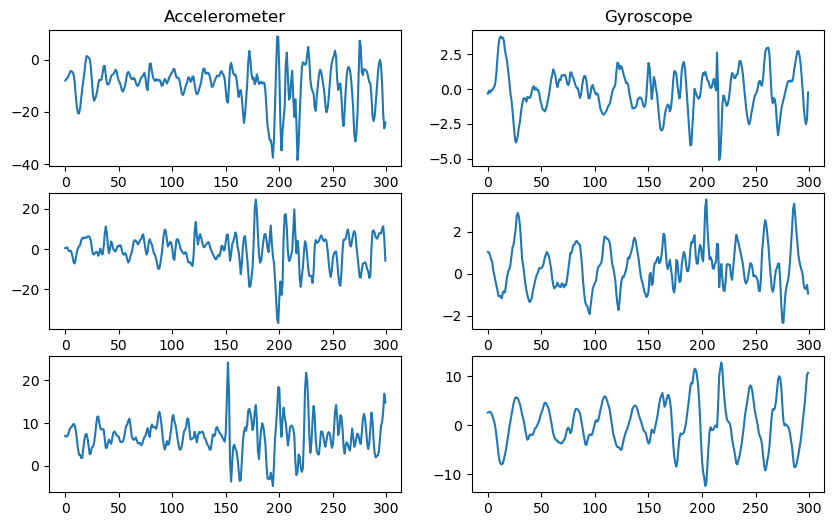

In [40]:
acc_RLA, gyro_RLA = virtual_IMU_dict["RLA"]
fig, axs = plt.subplots(3, 2, figsize=(10, 6))
start, end = 1000, 1300 # 10 secs
axs[0, 0].set_title("Accelerometer")
axs[0, 1].set_title("Gyroscope")
for i in range(3):
    axs[i, 0].plot(acc_RLA[start:end, i].detach().cpu().numpy(), label=f"acc_RLA_{i}")
    axs[i, 1].plot(gyro_RLA[start:end, i].detach().cpu().numpy(), label=f"gyro_RLA_{i}")